In [1]:
#Gradient Boosted Tree classifier - Takes longest in the previous test

In [2]:
import timeit
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

warnings.filterwarnings('ignore')

In [3]:
import os
def doublefile():
    file1=open('testingDup.csv','r')
    file2=open('testingNew.csv','w')
    count=0
    for line in file1:
        if count==0:
            file2.write(line)
            count=2
        else:
            file2.write(line)
            file2.write(line)
    file1.close()
    file2.close()
    os.remove('testingDup.csv')
    os.rename('testingNew.csv','testingDup.csv')

In [4]:
def first_dup_file():
    os.system('rm testingDup.csv')
    os.system('cp ADASYN.csv testingDup.csv')

In [5]:
def GB_SK_time():
    start_time=timeit.default_timer()
    df_pandas=pd.read_csv('testingDup.csv')
    X_train, X_test, y_train, y_test = train_test_split(df_pandas[df_pandas.columns.values[:-1]], df_pandas[['Biopsy']], random_state=42, test_size=0.1)
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)
    elapsed = timeit.default_timer() - start_time
    return (elapsed)

In [6]:
import findspark
findspark.init()
findspark.find()

from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
conf = SparkConf().setAppName("MyApp")


spark = SparkSession.builder.config(conf=conf).getOrCreate()


23/06/28 10:00:10 WARN Utils: Your hostname, Thuans-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.14 instead (on interface en0)
23/06/28 10:00:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/28 10:00:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/06/28 10:00:10 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/06/28 10:00:10 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [7]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier 


In [8]:
def GB_spark_time():
    start_time=timeit.default_timer()
    df_spark=spark.read.options(header='True',inferSchema='True').csv("testingDup.csv")
    Assembler=VectorAssembler(inputCols=df_spark.columns[:-1],outputCol='features')
    df_spark=Assembler.transform(df_spark)
    
    df_train_test=df_spark.select('features','Biopsy')
    gbt = GBTClassifier(featuresCol="features", labelCol="Biopsy", maxIter=10)
    gbt.fit(df_train_test)
    
    elapsed = timeit.default_timer() - start_time
    return (elapsed)


In [9]:
performance_df=pd.DataFrame(columns=['Platform','Size','ExecutionTime'])
first_dup_file()
for itt in range(10):
    print(itt)
    performance_df.loc[len(performance_df.index)] = ['Sk',itt+1,GB_SK_time()]
    performance_df.loc[len(performance_df.index)] = ['Spark',itt+1,GB_spark_time()]
    doublefile()



0
1
2
3
4


23/06/28 10:00:23 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


5
6
7
8


9


In [10]:
list(performance_df[performance_df['Platform']=='Sk']['Size'])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [11]:
performance_df

,Platform,Size,ExecutionTime
0,Sk,1,0.110263
1,Spark,1,5.197456
2,Sk,2,0.126359
3,Spark,2,1.664117
4,Sk,3,0.217357
5,Spark,3,1.639954
6,Sk,4,0.378548
7,Spark,4,1.661266
8,Sk,5,0.700354
9,Spark,5,1.991977


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


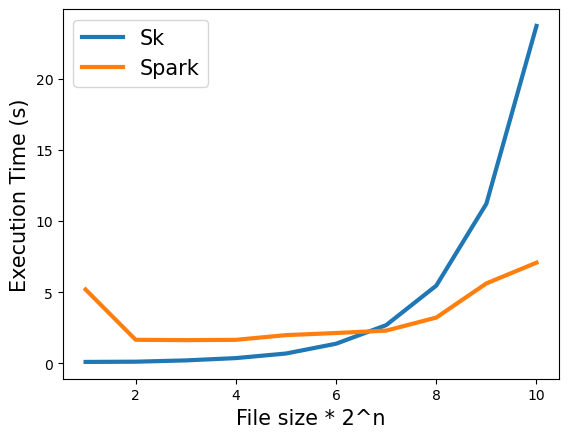

In [12]:
import matplotlib.pyplot as plt

#plt.rc('legend', fontsize=12)    # legend fontsize
plt.plot(list(performance_df[performance_df['Platform']=='Sk']['Size']),
       list(performance_df[performance_df['Platform']=='Sk']['ExecutionTime']),linewidth=3)
plt.plot(list(performance_df[performance_df['Platform']=='Spark']['Size']),
       list(performance_df[performance_df['Platform']=='Spark']['ExecutionTime']),linewidth=3)
plt.legend()
plt.xlabel('File size * 2^n',fontsize=15)
plt.ylabel('Execution Time (s)',fontsize=15)
plt.legend(["Sk", "Spark"], prop = { "size": 15 }, loc ="upper left")
plt.rcParams['font.size'] = 15

plt.show()

In [62]:
new_df=performance_df[performance_df['Platform']=='Sk'][['Size','ExecutionTime']]

In [63]:
new_df=new_df.rename(columns={'ExecutionTime':'SkLearn'})

In [64]:
new_df

,Size,SkLearn
0,1,0.110263
2,2,0.126359
4,3,0.217357
6,4,0.378548
8,5,0.700354
10,6,1.388288
12,7,2.694753
14,8,5.468835
16,9,11.219578
18,10,23.706132


In [65]:
spark_df=performance_df[performance_df['Platform']=='Spark'][['Size','ExecutionTime']]

In [67]:
spark_df

,Size,ExecutionTime
1,1,5.197456
3,2,1.664117
5,3,1.639954
7,4,1.661266
9,5,1.991977
11,6,2.140520
13,7,2.308474
15,8,3.224648
17,9,5.624002
19,10,7.079738


In [68]:
combine_df=new_df.merge(spark_df,on='Size')

In [69]:
combine_df=combine_df.rename(columns={'ExecutionTime':'Spark'})

In [72]:
%%html
<style>
/* Any CSS style can go in here. */
.dataframe th {
    font-size: 20px;
}
.dataframe td {
    font-size: 18px;
}
</style>

In [70]:
combine_df

,Size,SkLearn,Spark
0,1,0.110263,5.197456
1,2,0.126359,1.664117
2,3,0.217357,1.639954
3,4,0.378548,1.661266
4,5,0.700354,1.991977
5,6,1.388288,2.140520
6,7,2.694753,2.308474
7,8,5.468835,3.224648
8,9,11.219578,5.624002
9,10,23.706132,7.079738
